# Машинное обучение, ФКН ВШЭ

## Практическое задание 5. Решающие деревья

### Общая информация
Дата выдачи: 11.11.2021

Мягий дедлайн: 23:59MSK 23.11.2021

Жестокий дедлайн: 23:59MSK 26.11.2021

### О задании

Задание состоит из двух разделов:
1. В первом разделе вы научитесь применять деревья из sklearn для задачи классификации. Вы посмотрите какие разделяющие поверхности деревья строят для различных датасетов и проанализируете их зависимость от различных гиперпараметров.
2. Во втором разделе вы попробуете реализовать свое решающее дерево и сравните его со стандартное имплиментацией из sklearn. Вы также протестируете деревья на более сложных датасетах и сравните различные подходы к кодированию категориальных признаков.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-05-trees-Username.ipynb
* Модуль hw5code.py
* Ссылки на посылки в Яндекс.Контесте для обеих задач

В контест https://contest.yandex.ru/contest/31332/problems/ нужно отправить файл hw5code.py с реализованными функциями и классами.

Username — ваша фамилия и имя на латинице именно в таком порядке

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже:

__Оценка:__

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from matplotlib.colors import Colormap, ListedColormap
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder

sns.set(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

# 1. Решающие деревья. Визуализация.

В этой части мы рассмотрим два простых двумерных датасета сделанных с помощью `make_moons`, `make_circles` и посмотрим как ведет себя разделяющая поверхность в зависимости от различных гиперпараметров.

In [2]:
from sklearn.datasets import make_moons, make_circles, make_classification
datasets = [
    make_circles(noise=0.2, factor=0.5, random_state=42),
    make_moons(noise=0.2, random_state=42),
    make_classification(n_classes=3, n_clusters_per_class=1, n_features=2, class_sep=.8, random_state=3,
                        n_redundant=0., )
]

In [3]:
palette = sns.color_palette(n_colors=3)
cmap = ListedColormap(palette)

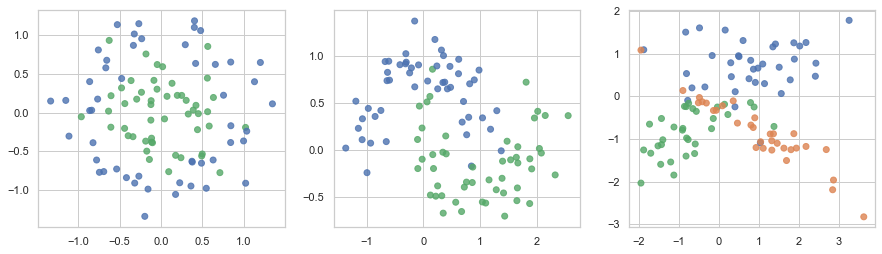

In [4]:
plt.figure(figsize=(15, 4))
for i, (x, y) in enumerate(datasets):
    plt.subplot(1, 3, i + 1)
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cmap, alpha=.8)

__Задание 1. (1 балл)__

Для каждого датасета обучите решающее дерево с параметрами по умолчанию, предварительно разбив выборку на обучающую и тестовую. Постройте разделящие поверхности (для этого воспользуйтесь функцией `plot_surface`, пример ниже). Посчитайте accuracy на обучающей и тестовой выборках. Сильно ли деревья переобучились?

In [5]:
def plot_surface(clf, X, y):
    plot_step = 0.01
    palette = sns.color_palette(n_colors=len(np.unique(y)))
    cmap = ListedColormap(palette)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap, alpha=0.3)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7,
                edgecolors=np.array(palette)[y], linewidths=2)

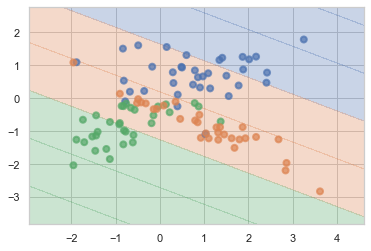

In [6]:
# Пример:
from sklearn.linear_model import LinearRegression
X, y = datasets[2]
lr  = LinearRegression().fit(X, y)
plot_surface(lr, X, y)

In [7]:
def ac_plot(data):
    X_train, X_test, y_train, y_test = train_test_split(data[0], data[1],stratify=y, random_state=42)
    trc = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

    y_pred_train = trc.predict(X_train)
    train_ac = accuracy_score(y_train, y_pred_train)

    y_pred_test = trc.predict(X_test)
    test_ac = accuracy_score(y_test, y_pred_test)

    plot_surface(trc, X_train, y_pred_train)
    print(train_ac)
    return test_ac, y_pred_test, X_test, trc

1.0


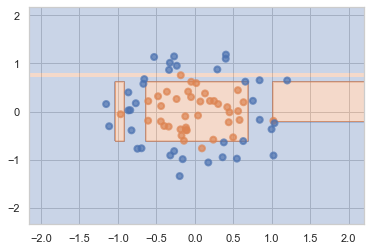

In [8]:
test_ac, y_pred_test, X_test, trc = ac_plot(datasets[0])

0.72


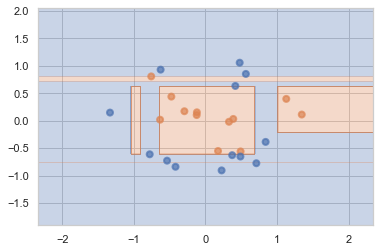

In [9]:
plot_surface(trc, X_test, y_pred_test)
print(test_ac)

1.0


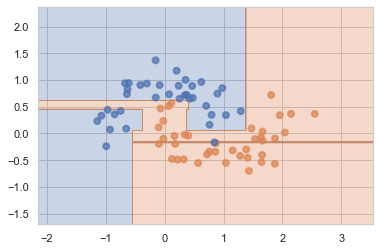

In [10]:
test_ac, y_pred_test, X_test, trc = ac_plot(datasets[1])

0.84


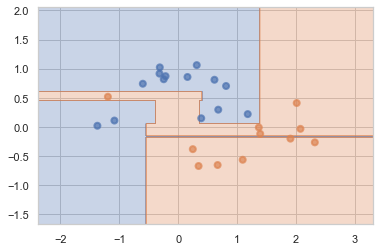

In [11]:
plot_surface(trc, X_test, y_pred_test)
print(test_ac)

1.0


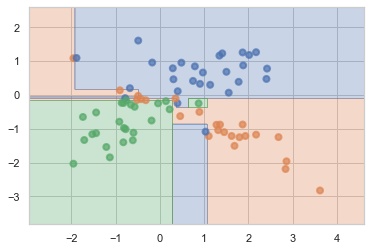

In [12]:
test_ac, y_pred_test, X_test, trc = ac_plot(datasets[2])

0.76


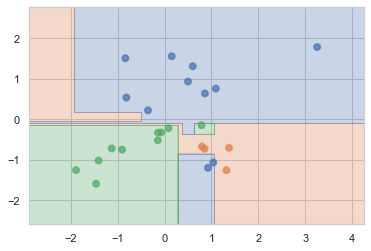

In [13]:
plot_surface(trc, X_test, y_pred_test)
print(test_ac)

__Ответ:__ как видно, дерево под каждую отдельную точку выброса делает лист, возникает переобучение, нужно пользоваться `min_samples_leaf`

__Задание 2. (1.5 балла)__

Попробуйте перебрать несколько параметров для регуляризации (напр. `max_depth`, `min_samples_leaf`). Для каждого набора гиперпараметров постройте разделяющую поверхность, выведите обучающую и тестовую ошибки. Можно делать кросс-валидацию или просто разбиение на трейн и тест, главное делайте каждый раз одинаковое разбиение, чтобы можно было корректно сравнивать (помните же, что итоговое дерево сильно зависит от небольшого изменения обучающей выборки?). Проследите как меняется разделяющая поверхность и обобщающая способность. Почему так происходит, одинаково ли изменение для разных датасетов?

In [14]:
def ac_plot_md_msl(data, max_depth, min_samples_leaf):
    X_train, X_test, y_train, y_test = train_test_split(data[0], data[1],stratify=y, random_state=43)
    trc = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf = min_samples_leaf, random_state=42).fit(X_train, y_train)

    y_pred_train = trc.predict(X_train)
    train_ac = accuracy_score(y_train, y_pred_train)

    y_pred_test = trc.predict(X_test)
    test_ac = accuracy_score(y_test, y_pred_test)
    plt.figure()
    plot_surface(trc, data[0], data[1])
    plt.show()
    return test_ac, train_ac

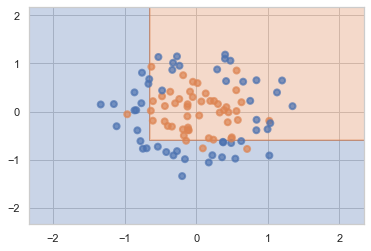

Train accuracy 0.76 Test accuracy 0.72 max_depth = 2 min_samples_leaf = 2


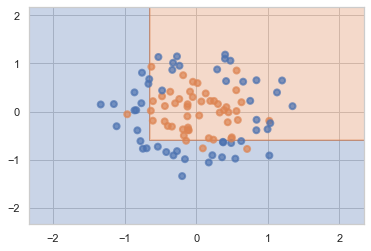

Train accuracy 0.76 Test accuracy 0.72 max_depth = 2 min_samples_leaf = 4


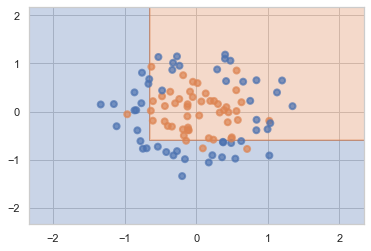

Train accuracy 0.76 Test accuracy 0.72 max_depth = 2 min_samples_leaf = 6


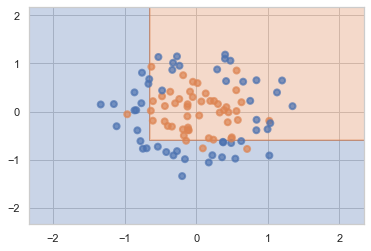

Train accuracy 0.76 Test accuracy 0.72 max_depth = 2 min_samples_leaf = 8


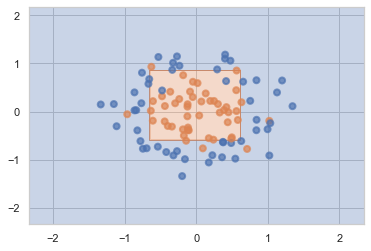

Train accuracy 0.92 Test accuracy 0.88 max_depth = 4 min_samples_leaf = 2


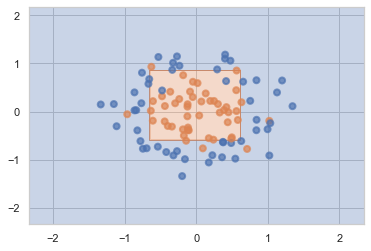

Train accuracy 0.92 Test accuracy 0.88 max_depth = 4 min_samples_leaf = 4


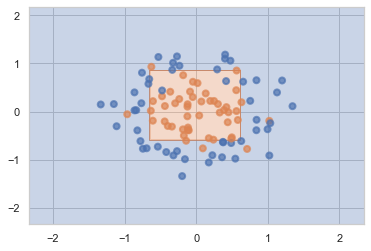

Train accuracy 0.92 Test accuracy 0.88 max_depth = 4 min_samples_leaf = 6


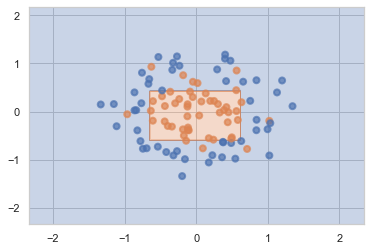

Train accuracy 0.8933333333333333 Test accuracy 0.84 max_depth = 4 min_samples_leaf = 8


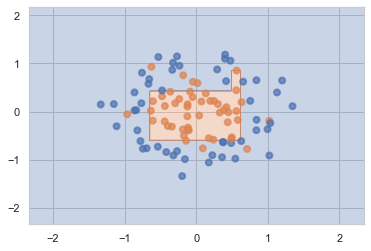

Train accuracy 0.92 Test accuracy 0.84 max_depth = 6 min_samples_leaf = 2


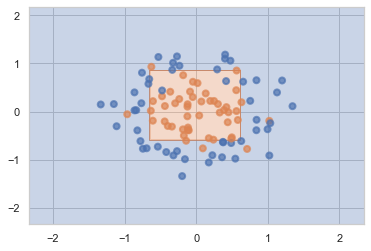

Train accuracy 0.92 Test accuracy 0.88 max_depth = 6 min_samples_leaf = 4


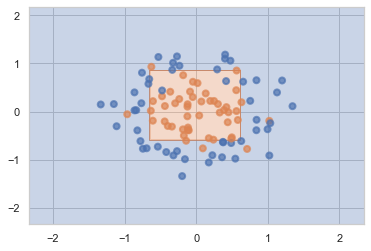

Train accuracy 0.92 Test accuracy 0.88 max_depth = 6 min_samples_leaf = 6


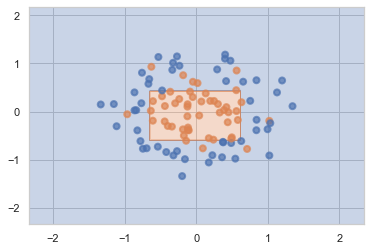

Train accuracy 0.8933333333333333 Test accuracy 0.84 max_depth = 6 min_samples_leaf = 8


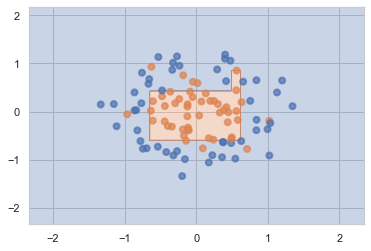

Train accuracy 0.92 Test accuracy 0.84 max_depth = 8 min_samples_leaf = 2


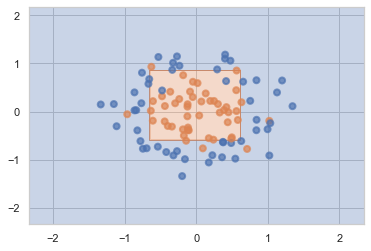

Train accuracy 0.92 Test accuracy 0.88 max_depth = 8 min_samples_leaf = 4


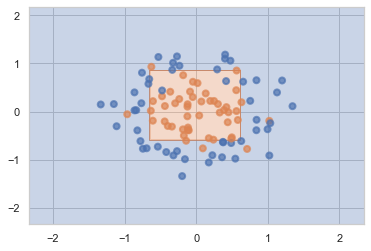

Train accuracy 0.92 Test accuracy 0.88 max_depth = 8 min_samples_leaf = 6


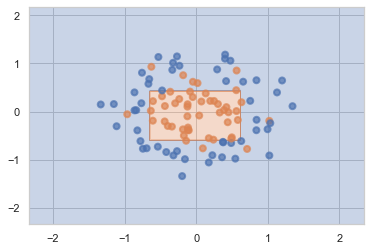

Train accuracy 0.8933333333333333 Test accuracy 0.84 max_depth = 8 min_samples_leaf = 8


Лучшие параметры max_depth = 4 min_samples_leaf = 2


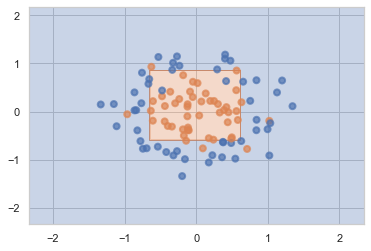

Train accuracy 0.92 Test accuracy 0.88


In [15]:
maxx = 0.0
md = 0
msl = 0
for i in range(2, 9, 2):
    for j in range(2, 9, 2):
        #for k, data in enumerate(datasets):
        test_ac, train_ac = ac_plot_md_msl(datasets[0], i, j)
        print('Train accuracy', train_ac, 'Test accuracy', test_ac, 'max_depth =', i, 'min_samples_leaf =', j)
        if test_ac > maxx:
            maxx = test_ac
            md = i
            msl = j
print('\n')
print('Лучшие параметры max_depth =', md, 'min_samples_leaf =', msl)
test_ac, train_ac = ac_plot_md_msl(datasets[0], md, msl)
print('Train accuracy', train_ac, 'Test accuracy', test_ac)

__Ответ:__ видно, что не стоит повышать значения  max_depth и min_samples_leaf с определенного значения, это не приведет к улучшению модели

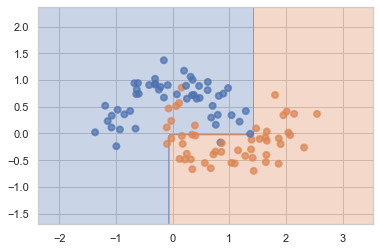

Train accuracy 0.8933333333333333 Test accuracy 0.92 max_depth = 2 min_samples_leaf = 2


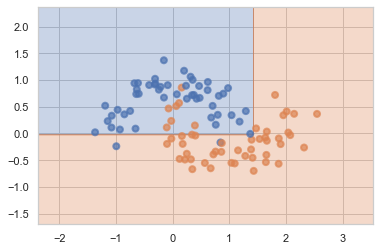

Train accuracy 0.8933333333333333 Test accuracy 0.92 max_depth = 2 min_samples_leaf = 4


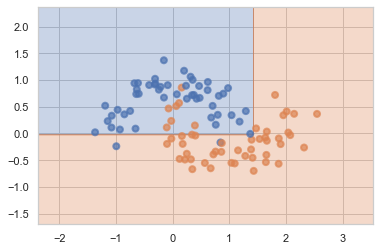

Train accuracy 0.8933333333333333 Test accuracy 0.92 max_depth = 2 min_samples_leaf = 6


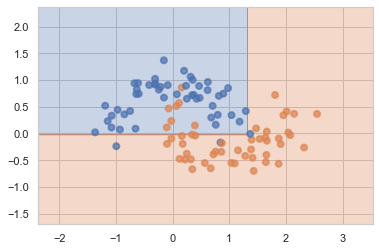

Train accuracy 0.88 Test accuracy 0.92 max_depth = 2 min_samples_leaf = 8


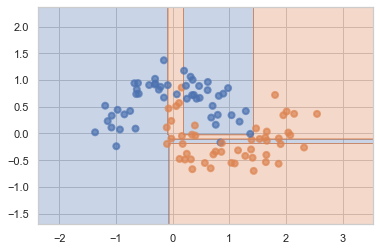

Train accuracy 0.96 Test accuracy 0.8 max_depth = 4 min_samples_leaf = 2


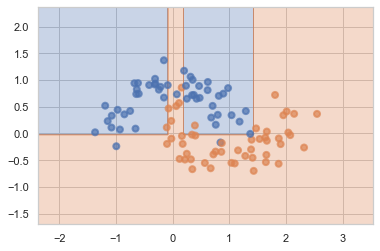

Train accuracy 0.96 Test accuracy 0.88 max_depth = 4 min_samples_leaf = 4


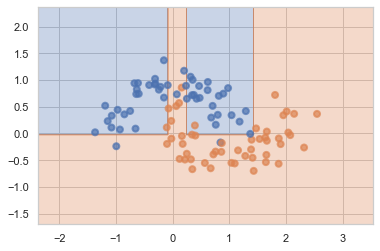

Train accuracy 0.9466666666666667 Test accuracy 0.84 max_depth = 4 min_samples_leaf = 6


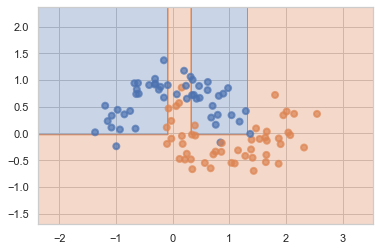

Train accuracy 0.9066666666666666 Test accuracy 0.84 max_depth = 4 min_samples_leaf = 8


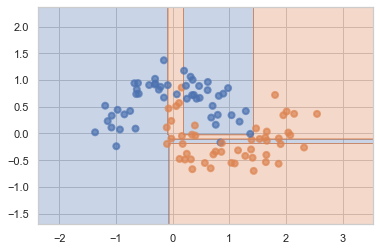

Train accuracy 0.96 Test accuracy 0.8 max_depth = 6 min_samples_leaf = 2


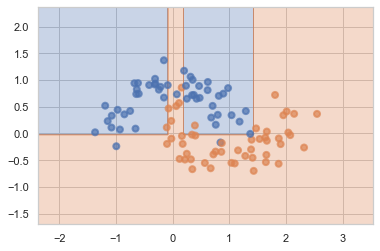

Train accuracy 0.96 Test accuracy 0.88 max_depth = 6 min_samples_leaf = 4


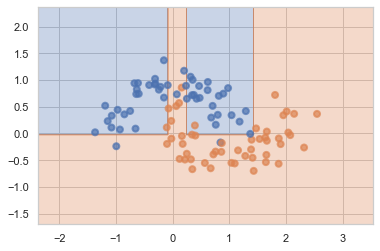

Train accuracy 0.9466666666666667 Test accuracy 0.84 max_depth = 6 min_samples_leaf = 6


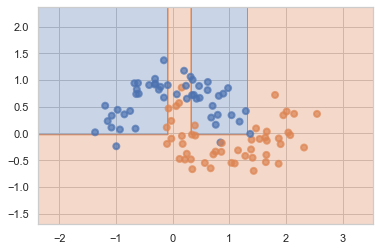

Train accuracy 0.9066666666666666 Test accuracy 0.84 max_depth = 6 min_samples_leaf = 8


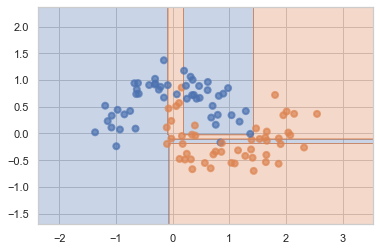

Train accuracy 0.96 Test accuracy 0.8 max_depth = 8 min_samples_leaf = 2


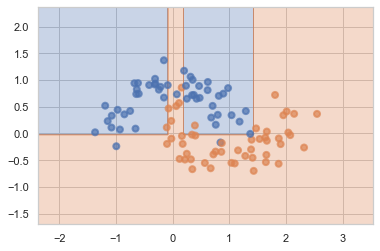

Train accuracy 0.96 Test accuracy 0.88 max_depth = 8 min_samples_leaf = 4


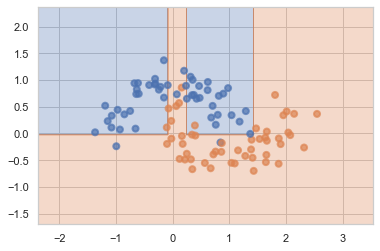

Train accuracy 0.9466666666666667 Test accuracy 0.84 max_depth = 8 min_samples_leaf = 6


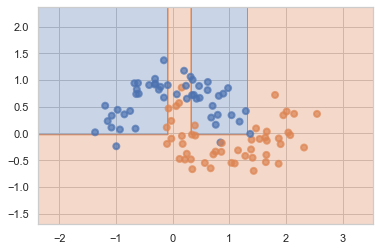

Train accuracy 0.9066666666666666 Test accuracy 0.84 max_depth = 8 min_samples_leaf = 8


Лучшие параметры max_depth = 2 min_samples_leaf = 8


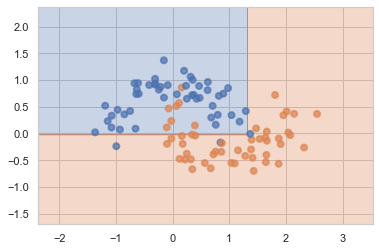

Train accuracy 0.88 Test accuracy 0.92


In [16]:
maxx = 0.0
md = 0
msl = 0
for i in range(2, 9, 2):
    for j in range(2, 9, 2):
        #for k, data in enumerate(datasets):
        test_ac, train_ac = ac_plot_md_msl(datasets[1], i, j)
        print('Train accuracy', train_ac, 'Test accuracy', test_ac, 'max_depth =', i, 'min_samples_leaf =', j)
        if test_ac >= maxx:
            maxx = test_ac
            md = i
            msl = j
print('\n')
print('Лучшие параметры max_depth =', md, 'min_samples_leaf =', msl)
test_ac, train_ac = ac_plot_md_msl(datasets[1], md, msl)
print('Train accuracy', train_ac, 'Test accuracy', test_ac)

__Ответ:__ чем больше глубина, тем на большее количество прямоугольников разбивается плоскость, следовательно увеличивается обобщающая спосбность. Но при каком-то увелечении глубины разделяющая поверхность перестает меняться. Что можно заметить, смотря на графиках где max_depth = 2 и max_depth = 8. На данном датасете параметр min_samples_leaf не играет особой роли, так как при наших параметрах максимальной глубины это никак не отражается на поведении модели.

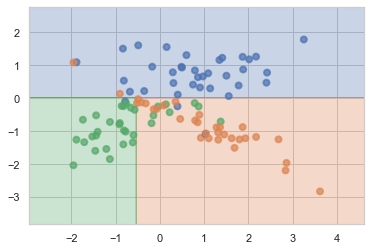

Train accuracy 0.88 Test accuracy 0.84 max_depth = 2 min_samples_leaf = 2


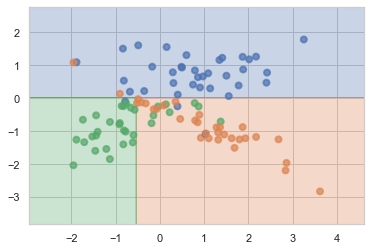

Train accuracy 0.88 Test accuracy 0.84 max_depth = 2 min_samples_leaf = 4


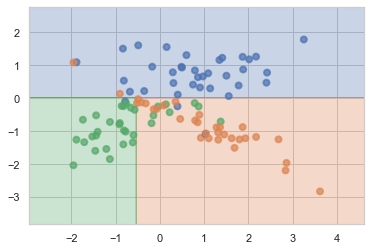

Train accuracy 0.88 Test accuracy 0.84 max_depth = 2 min_samples_leaf = 6


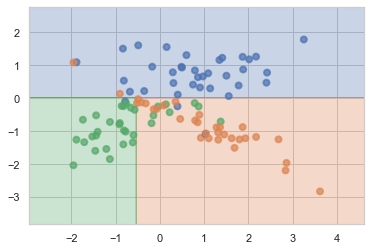

Train accuracy 0.88 Test accuracy 0.84 max_depth = 2 min_samples_leaf = 8


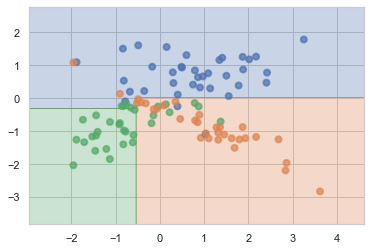

Train accuracy 0.88 Test accuracy 0.72 max_depth = 4 min_samples_leaf = 2


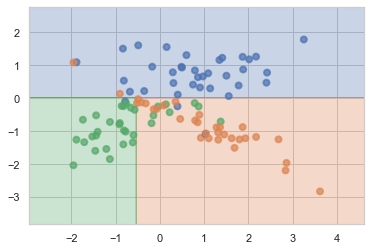

Train accuracy 0.88 Test accuracy 0.84 max_depth = 4 min_samples_leaf = 4


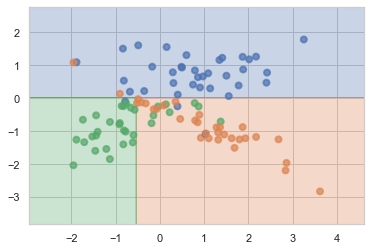

Train accuracy 0.88 Test accuracy 0.84 max_depth = 4 min_samples_leaf = 6


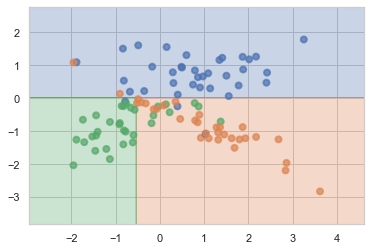

Train accuracy 0.88 Test accuracy 0.84 max_depth = 4 min_samples_leaf = 8


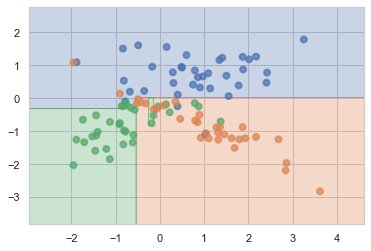

Train accuracy 0.9066666666666666 Test accuracy 0.72 max_depth = 6 min_samples_leaf = 2


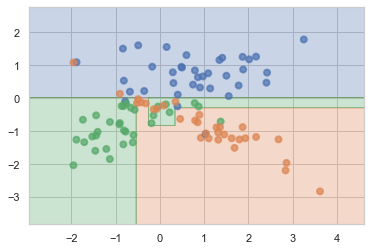

Train accuracy 0.9066666666666666 Test accuracy 0.88 max_depth = 6 min_samples_leaf = 4


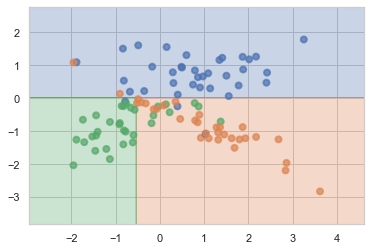

Train accuracy 0.88 Test accuracy 0.84 max_depth = 6 min_samples_leaf = 6


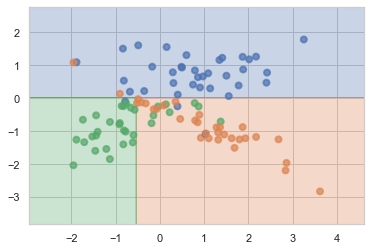

Train accuracy 0.88 Test accuracy 0.84 max_depth = 6 min_samples_leaf = 8


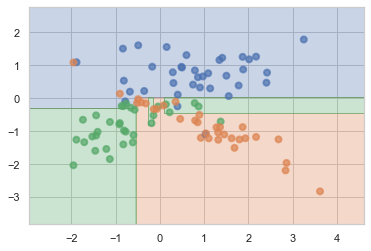

Train accuracy 0.9466666666666667 Test accuracy 0.72 max_depth = 8 min_samples_leaf = 2


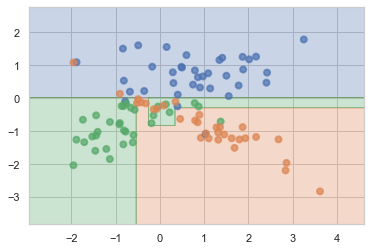

Train accuracy 0.9066666666666666 Test accuracy 0.88 max_depth = 8 min_samples_leaf = 4


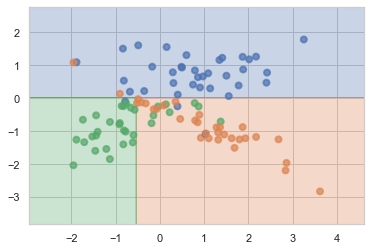

Train accuracy 0.88 Test accuracy 0.84 max_depth = 8 min_samples_leaf = 6


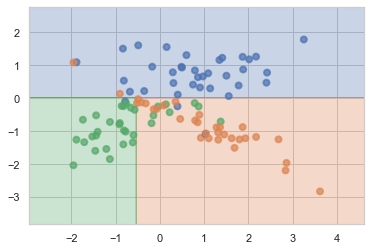

Train accuracy 0.88 Test accuracy 0.84 max_depth = 8 min_samples_leaf = 8


Лучшие параметры max_depth = 6 min_samples_leaf = 4


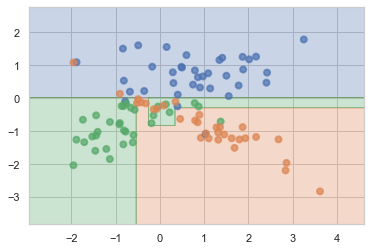

Train accuracy 0.9066666666666666 Test accuracy 0.88


In [17]:
maxx = 0.0
md = 0
msl = 0
for i in range(2, 9, 2):
    for j in range(2, 9, 2):
        #for k, data in enumerate(datasets):
        test_ac, train_ac = ac_plot_md_msl(datasets[2], i, j)
        print('Train accuracy', train_ac, 'Test accuracy', test_ac, 'max_depth =', i, 'min_samples_leaf =', j)
        if test_ac > maxx:
            maxx = test_ac
            md = i
            msl = j
print('\n')
print('Лучшие параметры max_depth =', md, 'min_samples_leaf =', msl)
test_ac, train_ac = ac_plot_md_msl(datasets[2], md, msl)
print('Train accuracy', train_ac, 'Test accuracy', test_ac)

__Ответ:__ начиная со значения min_samples_leaf = 4 мы можем заметить, что accuracy занижается

Мы же по сути ограничиваем переобучение двумя способами. При маленьком max_depth или большом min_samples_leaf происходит недообучение, а наоборот - переобучение. Стоит отметить, что при достаточно большом max_depth минимальное число объектов в листе не играет большой роли, и наоборот.

На moon датасете достаточно и глубины 2, а на других явно нет. Так что для разных датасетов явно оптимальные параметры тоже разные.

Итог1: Увеличение максимальной глубины и/или уменьшение минимального количества объектов выборки в листе приводит к увеличению качества на обучающей выборке и переобучению.

Итог2: при работе с DT нужен подбор параметров на какой-нибудь кросс-валидаци, чтобы модель не переобучилась.

# 2. Решающие деревья своими руками

В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__Задание 3. (1.5 балл)__

Реализуйте функцию find_best_split из модуля hw5code.py 

Contest ID: 59288899 https://contest.yandex.ru/contest/31332/run-report/59288899/

__Задание 4. (0.5 балла)__

Загрузите таблицу [students.csv](https://github.com/esokolov/ml-course-hse/blob/master/2021-fall/homeworks-practice/homework-practice-05-trees/students.csv) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака — класс" для всех пяти признаков.

In [18]:
df = pd.read_csv('students.csv')
df.columns

Index(['STG', 'SCG', 'STR', 'LPR', 'PEG', 'UNS'], dtype='object')

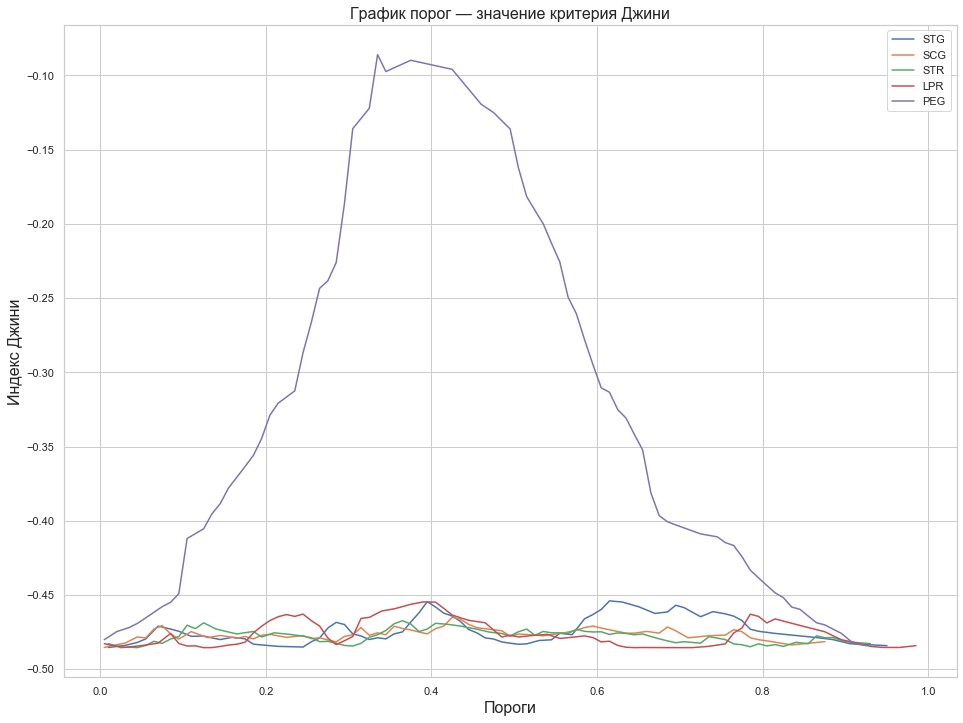

In [19]:
from hw5code import find_best_split

X = df.drop(columns=['UNS'])
y = df['UNS']
plt.figure(figsize=(16, 12))
plt.title('График порог — значение критерия Джини', size = 16)

for i, col in enumerate(X.columns):
    thresholds, ginis, best_th, best_g  = find_best_split(df[col].to_numpy(),  y.to_numpy())
    plt.plot(thresholds, ginis)
plt.legend(X.columns)
plt.xlabel('Пороги', size=16)
plt.ylabel('Индекс Джини', size=16)
plt.show()

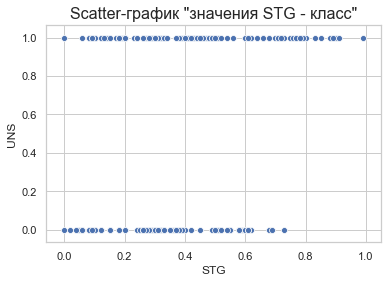

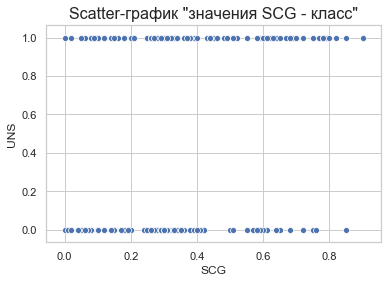

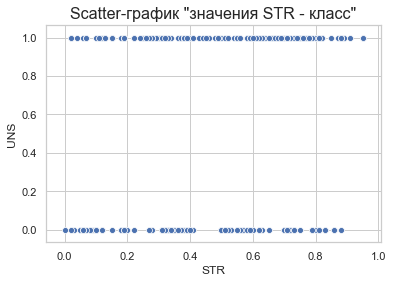

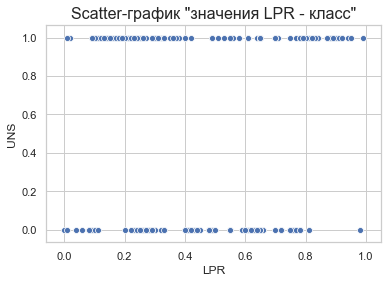

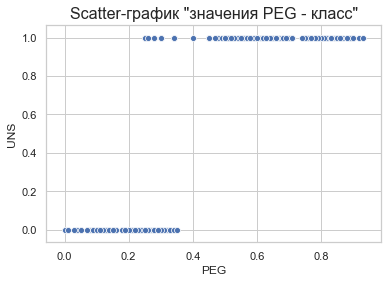

In [20]:
for sign in X.columns:
    plt.title('Scatter-график "значения ' + sign + ' - класс"', size=16)
    sns.scatterplot(df[sign], y)
    plt.show()

__Задание 5. (0.5 балла)__

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:**
1. PEG.
2. Да, взглянем на порог примерно равный 0,4, он хорошо разделяет признак. 
3. На первом графике кривая близка к 0. Чем ближе значение к порогу, тем больше будет Джини, поэтому график имеет подъем. Следующие графики выборки не должны пересекаться при наложении.
4. Если хотя бы с одной стороны от порога (где его можно поставить) большинство объектов одного класса, там возвышается первый график.

__Задание 6. (1.5 балла).__

Разберитесь с уже написанным кодом в классе DecisionTree модуля hw5code.py. Найдите ошибки в реализации метода \_fit_node. Напишите функцию \_predict_node.

 Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture07-trees.pdf) в разделе «Построение дерева». Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку. Ответ в листе: наиболее часто встречающийся класс в листе. Для категориальных признаков выполняется преобразование, описанное в лекции в разделе «Учет категориальных признаков».

Contest ID: 59291670 https://contest.yandex.ru/contest/31332/run-report/59291670/

__Задание 7. (0.5 балла)__

Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [30]:
from hw5code import DecisionTree

df = pd.read_csv('agaricus-lepiota.data')
df

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8119,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8120,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8121,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [39]:
label_encoder = LabelEncoder()
for sign in df.columns:
    df[sign] = label_encoder.fit_transform(df[sign])
X = df.drop(columns=['p'])
y = df['p']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
feat = ['categorical'] * X_train.shape[1]
trc = DecisionTree(feat)
trc.fit(X_train.values, y_train.values)
y_pred = trc.predict(X_test.values)
accuracy_score(y_test.values, y_pred)

1.0